## Link del github: 
https://github.com/Czar272/HT2-DM

In [ ]:
# Librerias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sb
import sklearn.cluster as cluster
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler
import sklearn.preprocessing
import scipy.cluster.hierarchy as sch
import skfuzzy as fuzz
import pylab
import sklearn.mixture as mixture
import pyclustertend 
import random
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import pdist
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [2]:
# Configuración inicial

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
dataset=pd.read_csv("movies.csv", encoding="latin1")

## Datos que no aportan información

id, title y original_title son datos que sirven más como nombres o identificadores de los datos, por lo que dentro de los grupos no aportarian mucha información.

homepage es solo un link a una página web, por lo que tampoco es relevante.

video solo tiene datos de si y no, pero no demuestra el alcance publicitario que tuvo la película. Por lo tanto, se vuelve irrelevante.

actorsCharacter solo indica los nombres de los personajes que interpretaron los actores dentro de sus respectivas película, nada que aporte información relevante.

productionCompany, productionCompanyCountry, productionCountry, productionCoAmount y productionCountriesAmount todos estos son datos sobre la producción de las películas. Estos datos pueden llegar a afectar mucho en una pelicula, pero en una agrupación es difícil darles lugar, ya que suelen ser muy variados

director indica el o los nombres de quien dirigió la película. Esto en un clustering no es muy útil, ya que no da para agrupaciones claras, pues no es como que se pueda saber la cálidad de un director solo por su nombre. Además, no hay forma de usar este dato para categorizar a los directores de forma directa.

actors indica los nombres de los actores y actrices que se ven involucrados en una película. Al igual que el director, esto no ayuda a las agrupaciones.

actorsAmount, castWomenAmount y castMenAmount son los datos sobre la cantidad de acatores y actrices dentro del elenco de la película. Aunque es un dato importante, ocurre lo mismo que con la producción, es un dato tan variado que puede ser difíl crear una agrupación fiel con ellos.

## Datos que pueden ser útiles para calcular los grupos

popularity es el índice de popularidad que tuvo la película semanalmente.

budget es la variable numérica que permite ver el presupuesto de las películas.

revenue es la variable numérica que muestra los ingresos de cada película.

voteAvg y voteCount ayudan a identificar las películas con mejor calificación y con más interacciones.

actorsAmount es la variable numérica que dice cuantos actores tiene cada película.

genresAmount es el valor numérico que se puede usar para saber como se agrupan películas con diferentes cantidades de géneros.

genres es un valor cualitativo que nos dice específicamente que generos tiene cada película. En este valor se pueden codificar los datos para un mejor análisis.

releaseDate es la varoable dada en formato de fecha que indica cuando se estrenó la pelicula.

actorsPopularity muestra la popularidad de cada actor dentro de la película. De esta lista se sacará un promedio para poder tratar mejor los datos. 

El enfoque de los grupos será ver las características de las películas que han sido un exito comercial


In [3]:
# limpia de datos con |

dataset['prime_genre'] = dataset['genres'].str.split('|').str[0]

def popularity_avg(actores_pop):
    try:
        valores = [float(x) for x in actores_pop.split('|') if x.replace('.', '', 1).isdigit()]
        return sum(valores) / len(valores) if valores else None 
    except:
        return None


dataset['actorsPopularity_avg'] = dataset['actorsPopularity'].apply(lambda x: popularity_avg(str(x)))

# Tomar solo el año de estreno

dataset['releaseDate'] = pd.to_datetime(dataset['releaseDate'], errors='coerce')
dataset['releaseYear'] = dataset['releaseDate'].dt.year


C:\Users\dgv31\AppData\Local\Temp\ipykernel_25500\3760735514.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  dataset_filtered.hist(ax=axs)


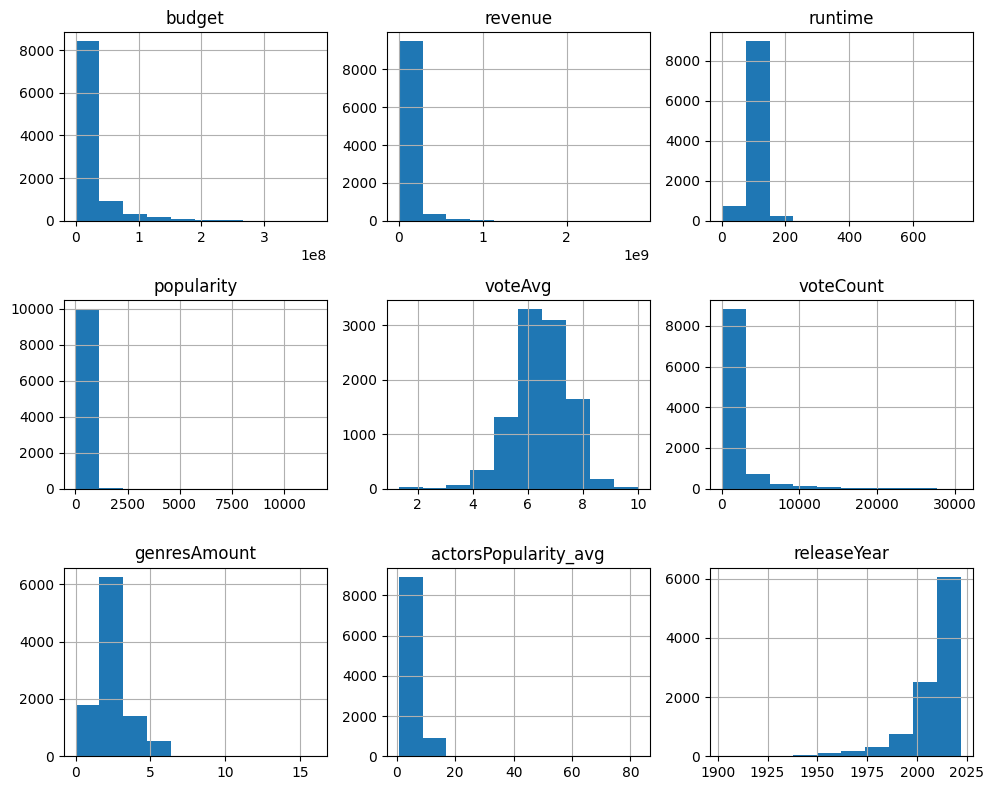

In [4]:
fig, axs = plt.subplots( figsize=(10, 8))
dataset_filtered = dataset.drop(['id', 'originalTitle', 'title', 'homePage', 'video', 'actors', 'director', 'actorsCharacter', 'actorsAmount', 'castWomenAmount', 'castMenAmount', 'productionCompanyCountry', 'productionCountry', 'productionCoAmount', 'productionCountriesAmount', 'productionCompany', 'genres', 'actorsPopularity','releaseDate'], axis='columns')
dataset_filtered.hist(ax=axs)
plt.tight_layout()
plt.show()

In [5]:
X = np.array(dataset_filtered[['budget','popularity']])
Y = np.array(dataset_filtered[['revenue']])
X.shape

(10000, 2)

In [6]:
# Fijar la semilla para obtener resultados reproducibles
random.seed(123)

# Escalar los datos para normalización
X_scale = sklearn.preprocessing.scale(X)

# Calcular la estadística de Hopkins
hopkins_stat = pyclustertend.hopkins(X_scale, len(X_scale))
print(f'Estadística de Hopkins: {hopkins_stat}')


Estadística de Hopkins: 0.0033873580573519735


In [7]:
# pyclustertend.vat(X_scale)

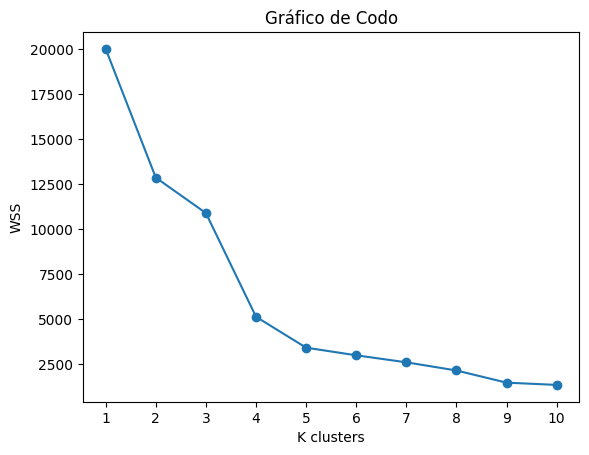

In [8]:
numeroClusters = range(1,11)
wcss = []
for i in numeroClusters:
    kmeans = cluster.KMeans(n_clusters=i)
    kmeans.fit(X_scale)
    wcss.append(kmeans.inertia_)

plt.plot(numeroClusters, wcss, marker='o')
plt.xticks(numeroClusters)
plt.xlabel("K clusters")
plt.ylabel("WSS")
plt.title("Gráfico de Codo")
plt.show()

Este gráfico de codo nos muestra que la suma de wss no tiene un descenso gradual hasta que k = 4.

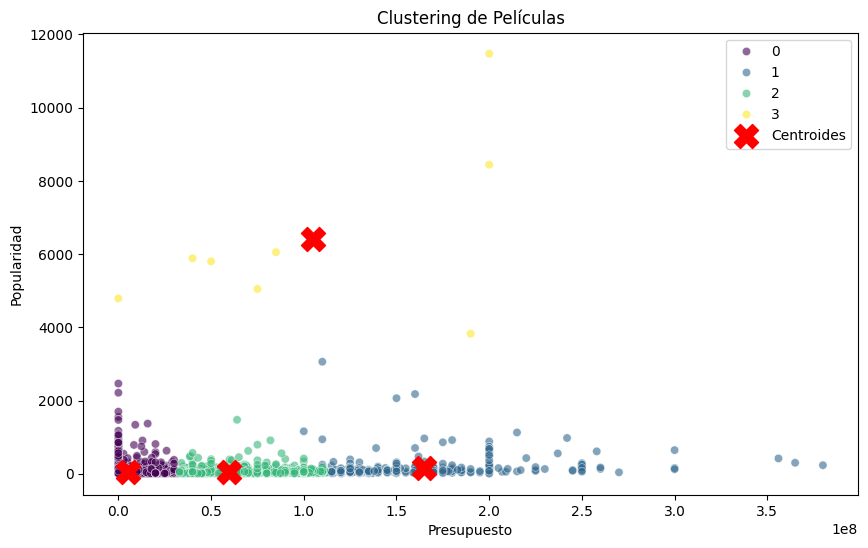

In [17]:
# Aplicar K-Means con K=4

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)  # Aplicamos el mismo escalado

# Aplicar K-Means con K=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scale)

# Agregar clusters al dataset
dataset_clustered = dataset_filtered.copy()
dataset_clustered['Cluster'] = clusters  

# Desnormalizar los centroides para graficarlos correctamente
centroids_original_scale = scaler.inverse_transform(kmeans.cluster_centers_)

# Visualizar los clusters con un scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=dataset_clustered['budget'], y=dataset_clustered['popularity'], hue=dataset_clustered['Cluster'], palette="viridis", alpha=0.6)
plt.scatter(centroids_original_scale[:, 0], centroids_original_scale[:, 1], s=300, c='red', marker='X', label='Centroides')
plt.xlabel("Presupuesto")
plt.ylabel("Popularidad")
plt.title("Clustering de Películas")
plt.legend()
plt.show()


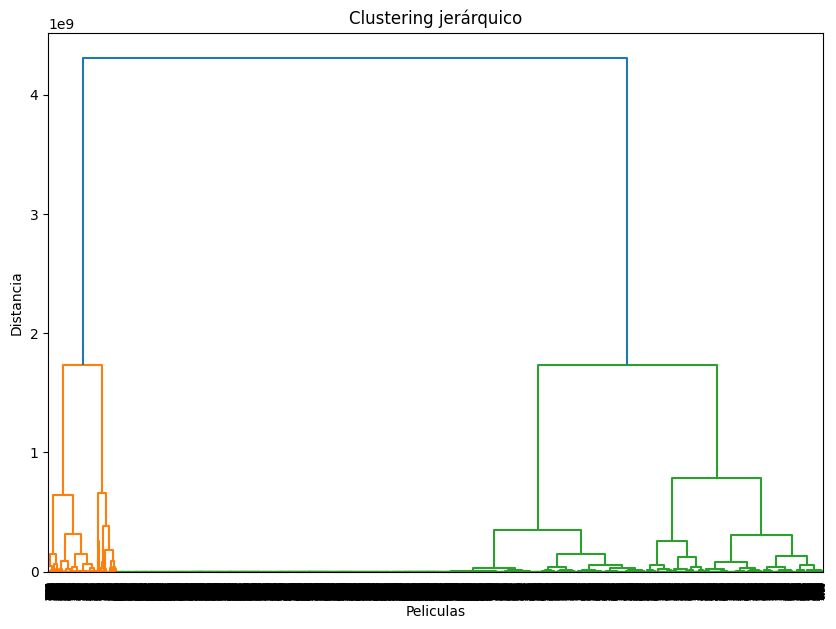

In [10]:
dist = pdist(X, metric = 'euclidean')
plt.figure(figsize=(10, 7))
linkage = shc.linkage(X, method='ward')
dendro = shc.dendrogram(linkage)
plt.title("Clustering jerárquico")
plt.xlabel("Peliculas")
plt.ylabel("Distancia")
plt.show()



For n_clusters = 3 The average silhouette_score is : 0.7690136161515511
For n_clusters = 4 The average silhouette_score is : 0.7542823620142444
For n_clusters = 5 The average silhouette_score is : 0.7480392588968793
For n_clusters = 6 The average silhouette_score is : 0.7472642292971623
For n_clusters = 7 The average silhouette_score is : 0.7505563618868492


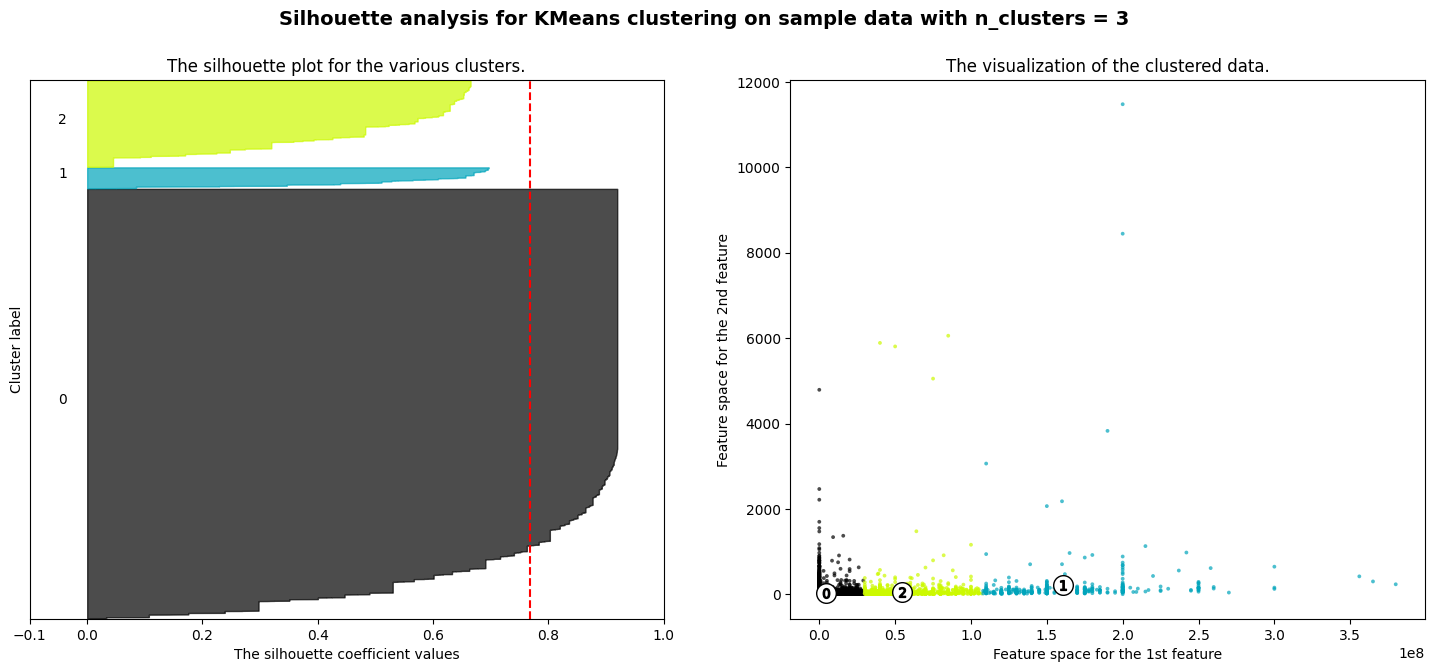

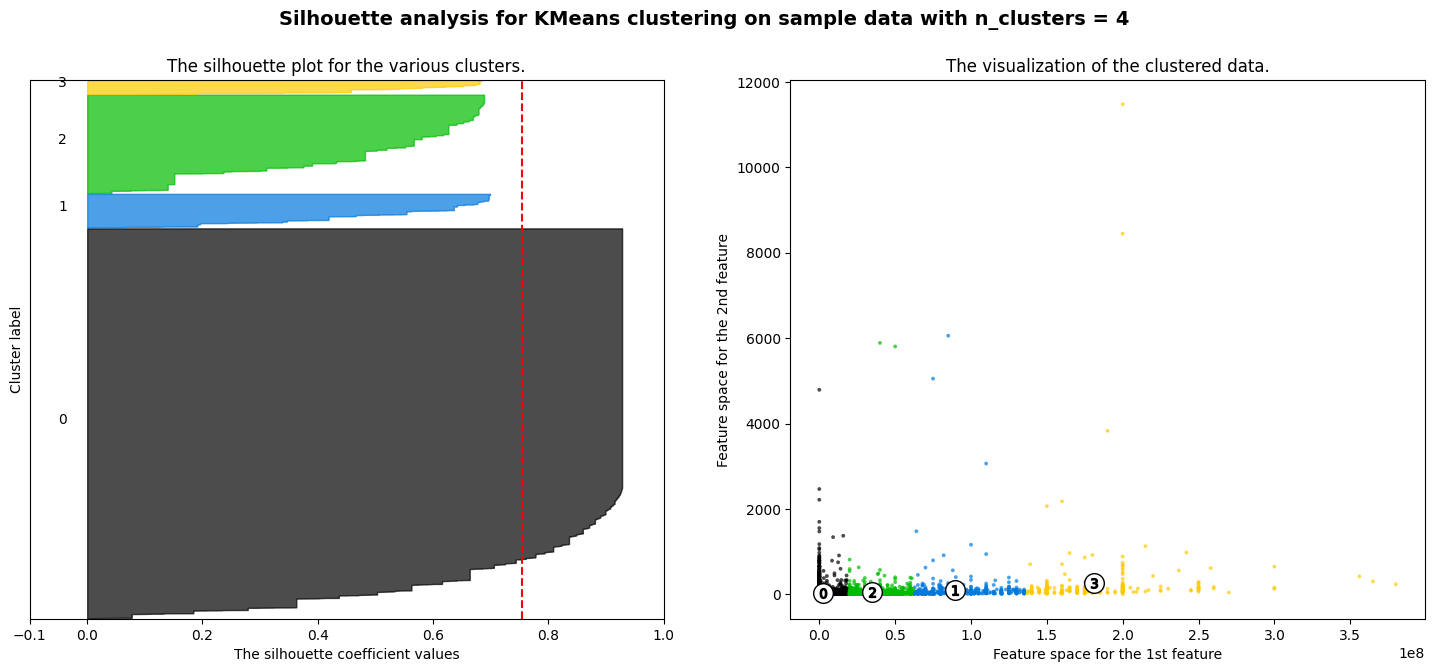

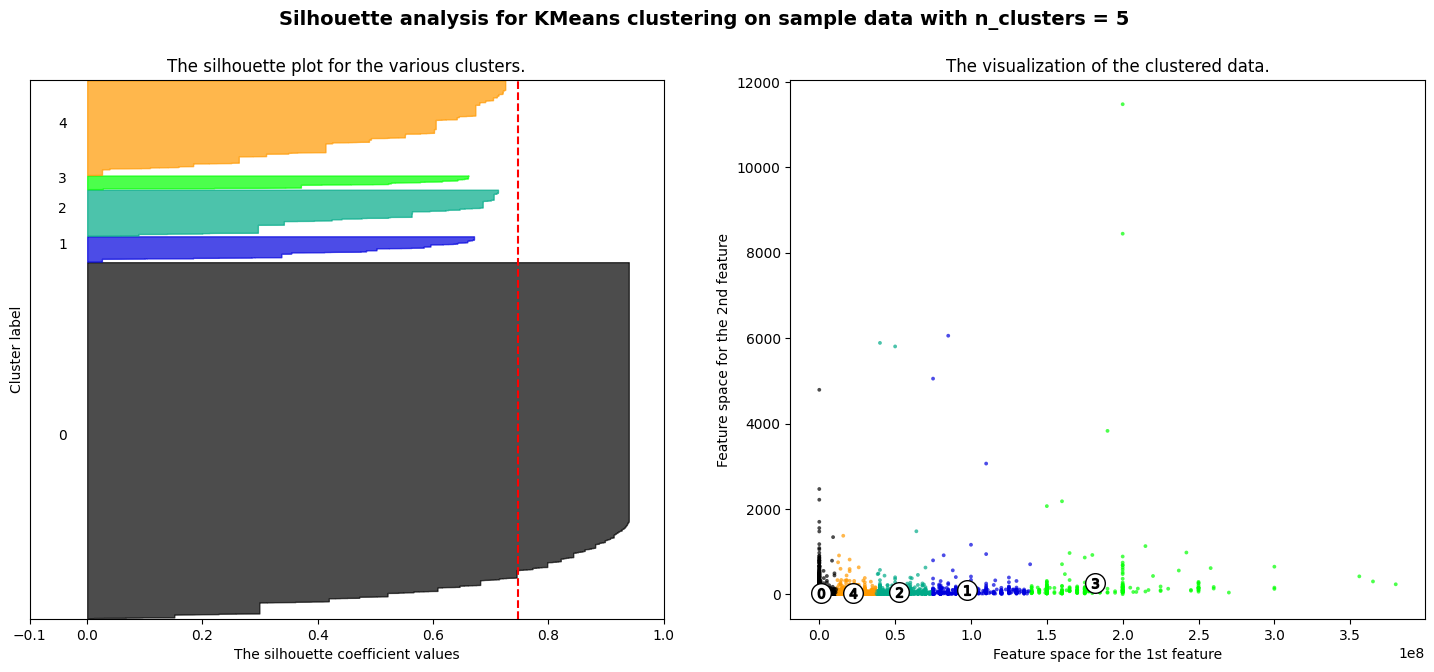

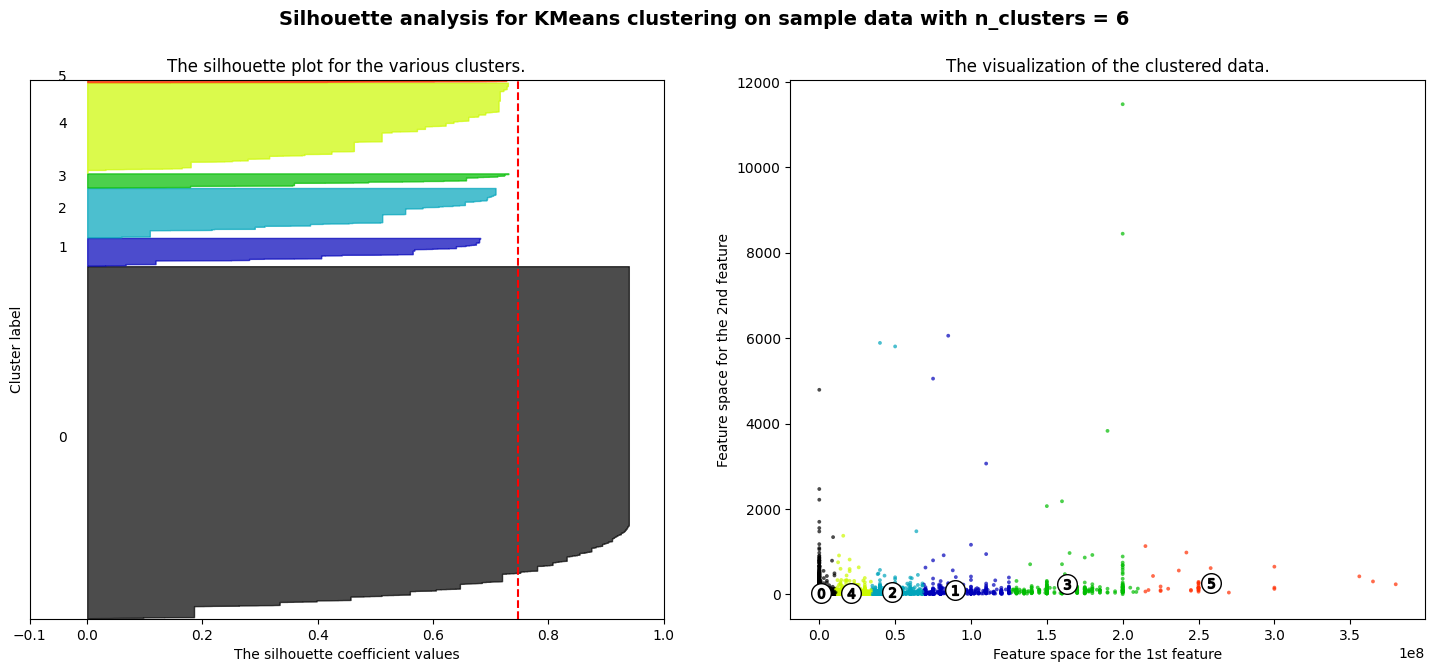

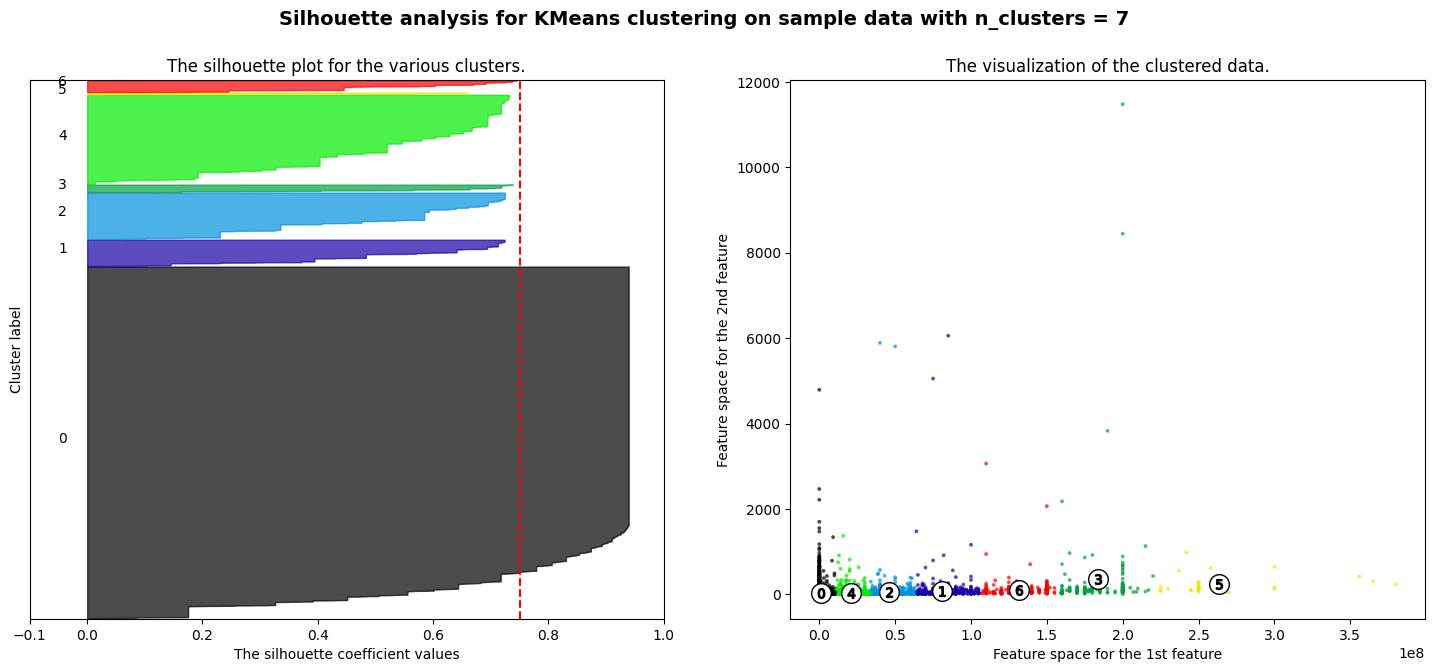

In [ ]:
range_n_clusters = [3, 4, 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Se usó una cantidad de clusterings entre 3 y 7 para ver cúal tenía una mejor siluaeta. Podemos ver que todos tuvieron valores similares, sin embargo, la silueta de los 3 clusters fue la que más se acercó a 1. Esto significa que según este gráfico, cuando hay 3 cluster, estos se encuentran bien agrupados y definido.

Aún así, no nos podemos confiar solamente en este dato, para saber la cantidad de clusters ideal. Podemos ver que en el dendograma existe un corte arriba de los 4 clusters. Lo que puede indicar que 4 clústers den resultados más fieles.

Esto último se refuerza al ver que en el gráfico de k-means, 4 es el número de clusters que muestra una mejor agrupación.